In [90]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import path
import matplotlib.patches as patches
from skimage import draw
import scipy.ndimage as ndimage
import Utils
import georasters as gr
import cv2
from Utils import doubleMADsfromMedian
from skimage.transform import resize
import pickle
import simplekml


# Parameters

In [91]:
path_T = "Pampa/THERMAL_06.tif"
path_String = "Pampa/BP-B-5.tif"
ZonaPV = 'BP-B-5'
path_kml_panel = 'Pampa/KML/Paneles_' + ZonaPV +'_classifier.kml'
path_dict = 'Pampa/KML/Mesa_' + ZonaPV + '.pickle'

GR_String = gr.from_file(path_String)
GR_T = gr.from_file(path_T)
geot_T = GR_T.geot
img_height, img_width = 128,128
## Load List in coordinate latitud and longitude ###
with open(path_dict, "rb") as fp:
    L_strings_coord = pickle.load(fp)

# Classifier each panel

In [92]:

epsilon = 0
matrix_expand_bounds = [[-epsilon, -epsilon],[+epsilon, -epsilon], [+epsilon, +epsilon], [-epsilon, +epsilon]]

for string_key in ['1', '20']:# L_strings_coord.keys():
    print(string_key)
    string = L_strings_coord[string_key]
    for panel_key in string['panels'].keys():
        panel = string['panels'][panel_key]
        Points =  Utils.gps2pixel(panel['points'], geot_T) + matrix_expand_bounds
        
        if not GR_T.raster.data[0,Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]].size == 0:
            Im = np.zeros((img_height, img_width, 3))
            Im[:,:,0] = cv2.resize(GR_T.raster.data[0,Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]], (img_width, img_height))
            Im[:,:,1] = Im[:,:,0].copy()
            Im[:,:,2] = Im[:,:,0].copy()
            panel['status'], panel['prob'] = classifier(Im)
        else:
            print('problem with coords panel: ', string_key, '_', panel_key)

plt.figure(figsize=(6, 6))
plt.imshow(Im.astype(int))

1


NameError: name 'classifier' is not defined

In [ ]:
panel

# Save KML Panels

In [ ]:

kml=simplekml.Kml()


for string_key in L_strings_coord.keys():
    
    string = L_strings_coord[string_key]
    points = string['points']
    
    for panel_key in string['panels'].keys():
        panel = string['panels'][panel_key]
        points = panel['points']
        
        pmt = kml.newpolygon(outerboundaryis = points)
        pmt.extendeddata.newdata(name= 'Id integer', value= str(string_key).zfill(3) + '_' + str(panel['id']).zfill(3))
        pmt.extendeddata.newdata(name= 'Id panel', value= str(panel['id']).zfill(3))
        pmt.extendeddata.newdata(name='Zona PV', value= ZonaPV)
        pmt.extendeddata.newdata(name='Cód. Fall', value= 0)
        pmt.extendeddata.newdata(name= 'Tipo falla', value= panel['status'])
        pmt.extendeddata.newdata(name= 'Mesa', value= string['id'])
        
kml.save(path_kml_panel)
print('Listo')

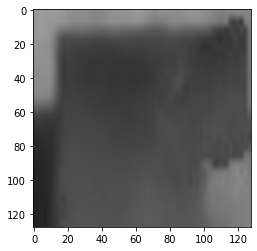

In [95]:
plt.imshow(Im.astype(int))